# Neural Network Training
### For now, this notebook serves as a basic NN training test.
### By Xiao Lin
### Reference: 
Neural Network Example https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci/blob/main/ClimateBench_tutorials/Neural_Network_example.ipynb
Neural Network Hyperparameter Tuning Example https://leap.2i2c.cloud/user/xiao-lin-ux/lab/tree/EAEE4000_ML_for_Env_Eng_Sci/ClimateBench_tutorials/CNN_keras_tuner.ipynb

In [ ]:
#pip install keras-tuner --upgrade

In [ ]:
from utils import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
import keras_tuner

from sklearn.metrics import r2_score

# Data Preprocessing
Split the data into training set and test set, and separate the inputs and the outputs

In [ ]:
train_df, test_df = df_prep(file_dir)
train_df

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,58,3,11,0,58
1,19,0,19,0,8
2,38,1,38,0,35
3,59,1,18,0,59
4,46,1,24,3,46
...,...,...,...,...,...
18765,103,3,12,27,103
18766,38,1,19,0,38
18767,51,1,46,0,51
18768,172,6,19,22,172


In [ ]:
test_df

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,235,3,158,1,235
1,123,1,35,0,123
2,39,1,39,1,38
3,37,2,15,0,37
4,39,1,39,1,18
...,...,...,...,...,...
4688,60,1,35,0,60
4689,40,1,29,3,40
4690,70,1,70,0,42
4691,52,2,13,0,52


In [ ]:
# Separate the inputs and the outputs
X_train_df = train_df.iloc[:, 1:5]
print('<======================= X_train =======================>\n')
print(X_train_df)
y_train_df = train_df.iloc[:, :1]
print('<======================= y_train =======================>\n')
print(y_train_df)
X_test_df = test_df.iloc[:, 1:5]
print('<======================= X_test =======================>\n')
print(X_test_df)
y_test_df = test_df.iloc[:, :1]
print('<======================= y_test =======================>\n')
print(y_test_df)

<======================= X_train =======================>

       CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
0                 3               11              0               58
1                 0               19              0                8
2                 1               38              0               35
3                 1               18              0               59
4                 1               24              3               46
...             ...              ...            ...              ...
18765             3               12             27              103
18766             1               19              0               38
18767             1               46              0               51
18768             6               19             22              172
18769             1               66              0               90

[18770 rows x 4 columns]
<======================= y_train =======================>

       AQI Value
0          

# Data Normalization
We tried to use different data normalization strategies to address the skewness in the input distribution
The following four strategies are implemented:
1. Standardization as normal distribution: Find the mean and standard veviation of the input distribution and convert it to a standard normal distribution.
2. Normalization (min-max): Set the min and max values of the input distribution to 0 and 1, and normalize the distribution to values between 0 and 1 linearly.
3. Log transformation: Try to transform a skewed distribution to a normal distribution by taking the log of the input distribution.
4. Square root transformation: Try to transform a skewed distribution to a normal distribution by taking the square root of the input distribution.

In [132]:
# Select different normalization strategies, range is 1-4
method_selection = 3

if method_selection == 1:
    # Method 1. Standardization as normal distribution
    mean, std = X_train_df.mean(), X_train_df.std()
    X_train_df   = (X_train_df - mean)/std
    X_test_df    = (X_test_df - mean)/std
elif method_selection == 2:
    # Method 2. Normalization (min-max)
    max_val, min_val = X_train_df.max(), X_train_df.min()
    test_range = max_val - min_val
    X_train_df   = X_train_df/test_range
    X_test_df    = X_test_df/test_range
elif method_selection == 3:
    # Method 3. Log transformation
    # Avoid taking the log of 0s
    X_train_df   = pd.DataFrame(np.ma.log(X_train_df.values).filled(0), index=X_train_df.index, columns=X_train_df.columns)
    X_test_df    = pd.DataFrame(np.ma.log(X_test_df.values).filled(0), index=X_test_df.index, columns=X_test_df.columns)
    mean, std = X_train_df.mean(), X_train_df.std()
    X_train_df   = (X_train_df - mean)/std
    X_test_df    = (X_test_df - mean)/std
elif method_selection == 4:
    # Method 4. Square root transformation
    X_train_df   = np.sqrt(X_train_df)
    X_test_df    = np.sqrt(X_test_df)
    mean, std = X_train_df.mean(), X_train_df.std()
    X_train_df   = (X_train_df - mean)/std
    X_test_df    = (X_test_df - mean)/std
    
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test_truth = y_test_df.to_numpy()

print(X_train)
print(X_train.shape,y_train.shape)

[[ 1.80435902 -1.21368814 -0.75267281  0.10772965]
 [-0.49305646 -0.48926437 -0.75267281 -2.70244377]
 [-0.49305646  0.42947696 -0.75267281 -0.60877885]
 ...
 [-0.49305646  0.68271372 -0.75267281 -0.07472207]
 [ 3.25386681 -0.48926437  2.63359252  1.64977956]
 [-0.49305646  1.16122375 -0.75267281  0.7309985 ]]
(18770, 4) (18770, 1)


In [20]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

'''
max_val, min_val = X_train_df.max(), X_train_df.min()
test_range = max_val - min_val
print(max_val)
print(min_val)

X_train_df   = X_train_df / test_range
X_test_df    = X_test_df / test_range
'''

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test_truth = y_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(18770, 4) (18770, 1)


# Neural Network Construction
Set the hyperparameters and construct the NN by creating layers

In [ ]:
n_trials = 20 # Total number of trials to run hyperparameter tuning
num_epochs     = 100
minibatch_size = 64

'''
# set hyperparameters
n_neuron       = 256
activation     = 'tanh' #'linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 16
N_layers       = 3 # number of hidden layers
'''

"\n# set hyperparameters\nn_neuron       = 256\nactivation     = 'tanh' #'linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)\nnum_epochs     = 100\nlearning_rate  = 0.001\nminibatch_size = 16\nN_layers       = 3 # number of hidden layers\n"

In [ ]:
def build_model(hp):

    # Options for hyperparameters
    hp_n_neuron = hp.Choice('n_neuron', values = [8, 16, 32, 64, 128, 256])
    hp_activation = hp.Choice('activation', values = ['linear', 'tanh', 'relu', 'sigmoid'])
    hp_n_layers = hp.Choice('n_layers', values = [1, 2, 3, 4])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    # Build a neural network from scratch
    model = Sequential()

    model.add(Dense(hp_n_neuron,  activation=hp_activation, name="hidden_layer_1" ,input_shape=(X_train.shape[1],)))
    for n in range(hp_n_layers-1):
        model.add(Dense(hp_n_neuron,  activation=hp_activation, name="hidden_layer_"+str(n+2))) 

    model.add(Dense(y_train.shape[1],  activation='linear', name="output_layer")) # the output layer


    model.compile(loss=hp_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return model
    

In [ ]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model, 
                                        max_trials=n_trials,
                                        seed=42,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='random_search_NN_20trials')

Reloading Tuner from random_search/random_search_NN_20trials/tuner0.json


In [ ]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 5
n_neuron (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256], 'ordered': True}
activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'tanh', 'relu', 'sigmoid'], 'ordered': False}
n_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3, 4], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


# Neural Network Training

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [ ]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               1280      
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               65792     
                                                                 
 hidden_layer_3 (Dense)      (None, 256)               65792     
                                                                 
 hidden_layer_4 (Dense)      (None, 256)               65792     
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 198,913
Trainable params: 198,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  20
{'n_neuron': 256, 'activation': 'relu', 'n_layers': 4, 'learning_rate': 0.01, 'loss': 'mae'}
Ranking # 2 of best tuning, total trials =  20
{'n_neuron': 16, 'activation': 'tanh', 'n_layers': 2, 'learning_rate': 0.01, 'loss': 'mae'}
Ranking # 3 of best tuning, total trials =  20
{'n_neuron': 128, 'activation': 'sigmoid', 'n_layers': 1, 'learning_rate': 0.001, 'loss': 'mae'}


In [ ]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

<<<<<<< local


Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 8.8909 - val_loss: 3.1109
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 3.5798 - val_loss: 6.3244
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 3.4708 - val_loss: 2.9609
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 2.9228 - val_loss: 1.3880
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 2.7984 - val_loss: 4.7473
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 2.4656 - val_loss: 1.4617
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 2.1517 - val_loss: 2.6508
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 1.9701 - val_loss: 0.9309
Epoch 9/100
235/235 [==============================] - 2s 7ms/step - loss: 2.4578 - val_loss: 0.9259
Epoch 10/100
235/235 [==============================] - 1s 6ms/step - loss: 1.8982 - val_lo

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 9.0466 - val_loss: 3.7993
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 4.0625 - val_loss: 2.1828
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 3.6462 - val_loss: 2.6244
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 2.9145 - val_loss: 5.9283
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 2.7804 - val_loss: 2.1542
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 3.0002 - val_loss: 5.3138
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 2.4610 - val_loss: 2.1024
Epoch 8/100
235/235 [==============================] - 1s 3ms/step - loss: 2.5934 - val_loss: 1.6031
Epoch 9/100
235/235 [==============================] - 1s 3ms/step - loss: 2.0190 - val_loss: 1.7860
Epoch 10/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2813 - val_lo

>>>>>>> remote


<<<<<<< local


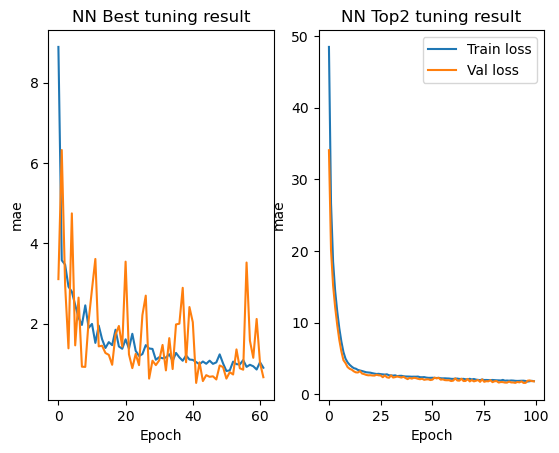

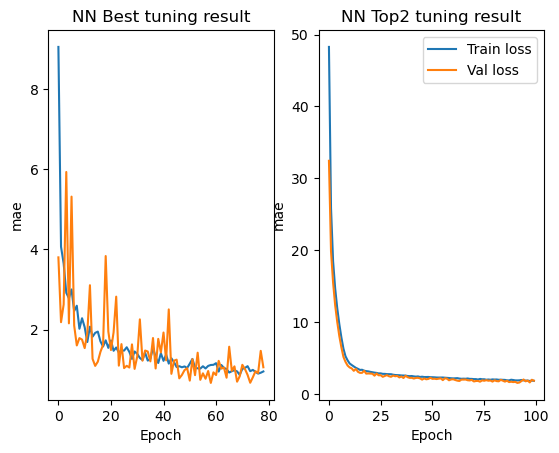

>>>>>>> remote


In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'NN Best tuning result'
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'NN Top2 tuning result'
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [ ]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_best.save(os.path.join(model_path,'NN_model_randomsearch_20trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'NN_model_randomsearch_20trials_rank2.h5'))

In [ ]:
# reload the saved model
# ---------- best tuning ----------
model_best = load_model(os.path.join(model_path,'NN_model_randomsearch_20trials_rank1.h5'))
# ---------- rank #2 tuning ----------
model_top2 = load_model(os.path.join(model_path,'NN_model_randomsearch_20trials_rank2.h5'))

<<<<<<< local


147/147 [==============================] - 0s 897us/step


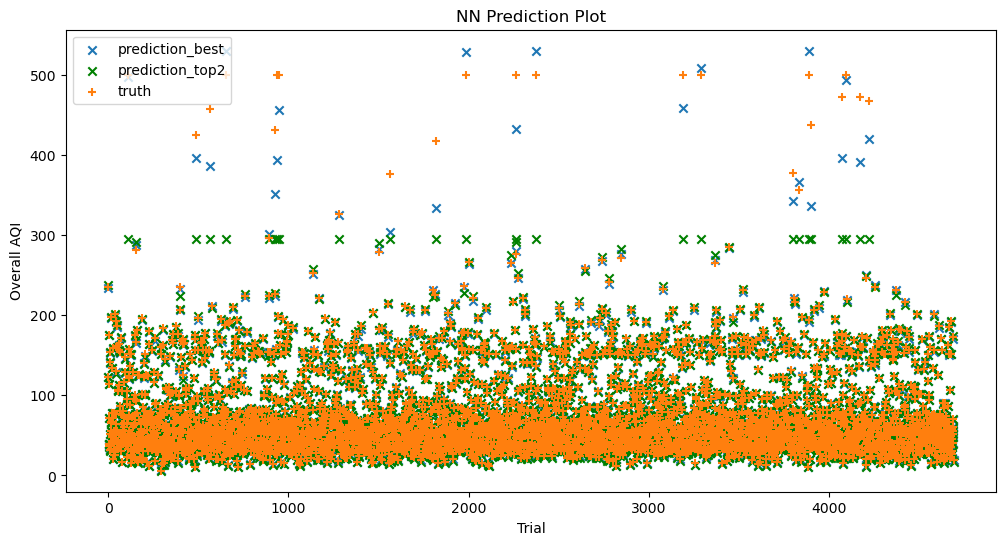

147/147 [==============================] - 0s 613us/step


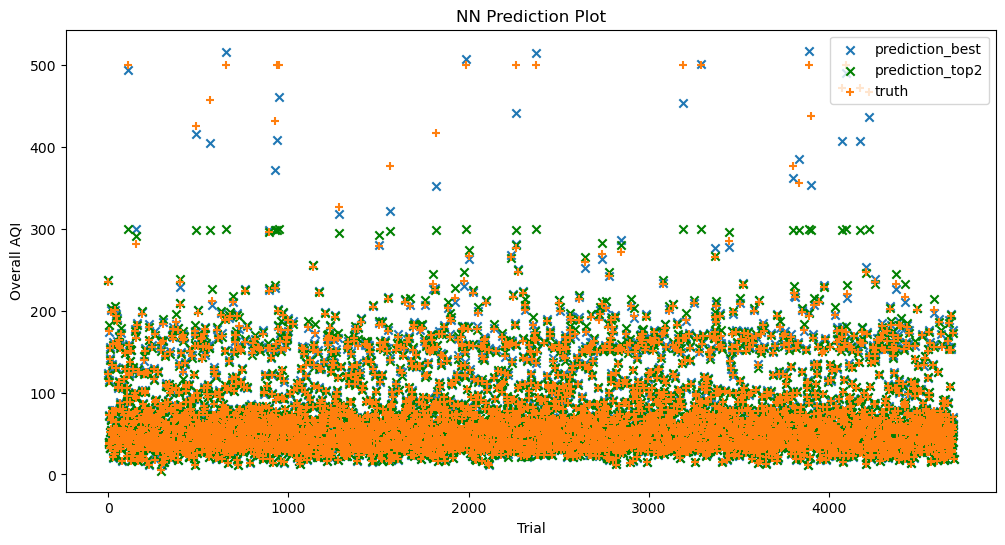

>>>>>>> remote


In [ ]:
# Generate prediction from the two models
y_test_best_pre = model_best.predict(X_test)
y_test_top2_pre = model_top2.predict(X_test)

trial_test = 4693 # There are 4693 test datapoints
trial_array = np.arange(trial_test)
y_test_truth = np.reshape(y_test_truth, -1)
y_test_best_pre = np.reshape(y_test_best_pre, -1)
y_test_top2_pre = np.reshape(y_test_top2_pre, -1)
    
fig,ax = plt.subplots(figsize=(12,6))
plt.title('NN Prediction Plot')
plt.scatter(trial_array, y_test_best_pre, marker='x', label='prediction_best')
plt.scatter(trial_array, y_test_top2_pre, marker='x', color='g', label='prediction_top2')
plt.scatter(trial_array, y_test_truth, marker='+', label='truth')

ax.legend()
ax.set_xlabel('Trial')
ax.set_ylabel('Overall AQI')

plt.show()

<<<<<<< local


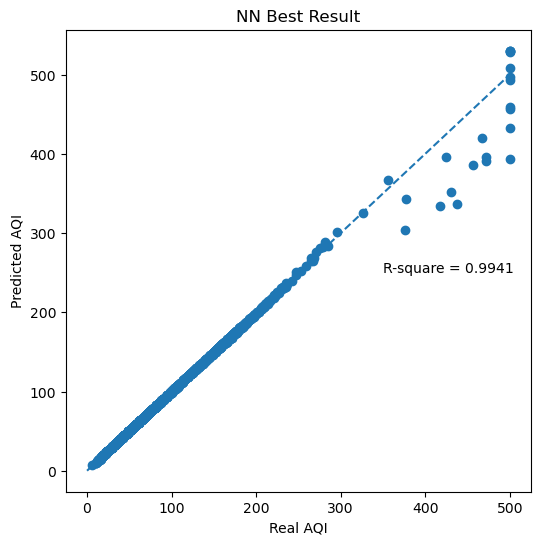

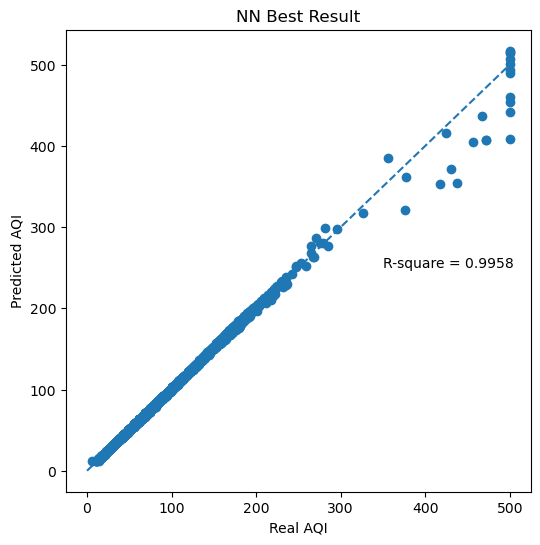

>>>>>>> remote


In [ ]:
fig,ax = plt.subplots(figsize=(6,6))

r2_best = r2_score(y_test_truth, y_test_best_pre)
plt.title('NN Best Result', fontsize=12)
plt.text(350, 250, f'R-square = {r2_best:.4}', fontsize=10)
plt.scatter(y_test_truth, y_test_best_pre, marker='o')
line_array = np.arange(max(y_test_truth))
plt.plot(line_array, line_array, linestyle='dashed')
ax.set_xlabel('Real AQI')
ax.set_ylabel('Predicted AQI')

plt.show()

<<<<<<< local


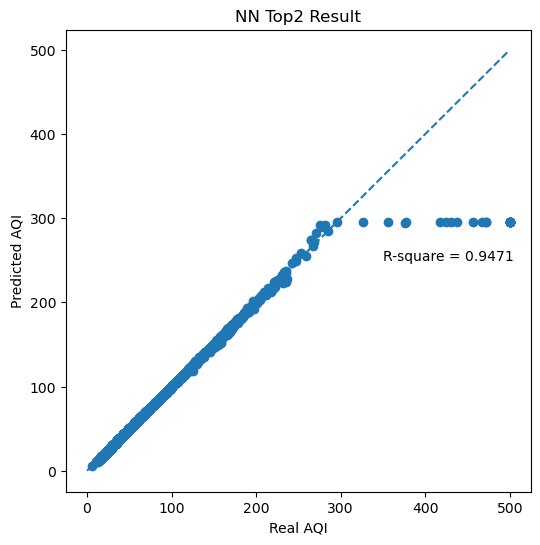

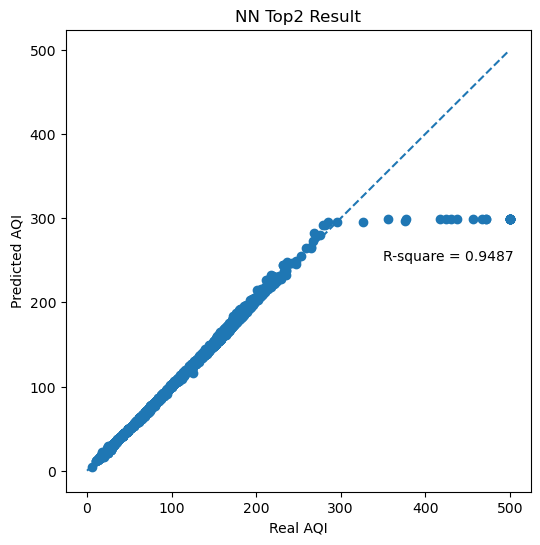

>>>>>>> remote


In [ ]:
fig,ax = plt.subplots(figsize=(6,6))

r2_top2 = r2_score(y_test_truth, y_test_top2_pre)
plt.title('NN Top2 Result', fontsize=12)
plt.text(350, 250, f'R-square = {r2_top2:.4}', fontsize=10)
plt.scatter(y_test_truth, y_test_top2_pre, marker='o')
line_array = np.arange(max(y_test_truth))
plt.plot(line_array, line_array, linestyle='dashed')
ax.set_xlabel('Real AQI')
ax.set_ylabel('Predicted AQI')

plt.show()